# modelling validation influence diagrams for high tech systems

<a id = "table_of_content"> </a>
### table of contents
- [prerequisites](#prerequisites)
- [helpers](#helpers)
- [create diagram](#create_diagram)
- [display diagram and tables](#diagram_tables)
- [modelling and validating systems and health](#model_validate_system)
- [modelling and validating Replace Decision](#model_validate_decision)
- [modelling and validating Tests](#modelling_validating_tests)
  - [cmponent health test, LIMID](#joep_component_health_test)
  - [component health test, ID](#component_health_test_ID)
  - [improved health test](#improved_test)
  - [output test](#output_test)
  - [other tests](#other_tests)
- [Multiple decisions](#decisions)

<a id="prerequisites"></a>
# prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math

In [3]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()


see if styles are working, comment in red
<div class="mycomment"> Should test outcome be in the initial diagram or should it be introduced when test is done? Test outcome impacts health 1:1, why not use health for testoutcome?</div>


In [4]:
sys.path.insert(1, "/workspaces/ou-af/problem1/iteratie1")

In [5]:
# import de code
import src.system as system
import src.diagrambuilder as builder
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs

[Back to table of content](#table_of_content)

<a id="helpers"></a>
# reporting helpers

In [6]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)

In [7]:
def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))

In [8]:
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)



In [9]:
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))

In [10]:
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

[Back to table of content](#table_of_content)

<a id="create_diagram"></a>
## create diagam

In [11]:
# gather specs for a system
# system = light + replacedecision + test
components = [componentspecs.light, componentspecs.switch]
connections = [connectionspecs.wire, connectionspecs.wire2]
tests = [testspecs.testObserveHealth]
assembly = {
    "components"  : components,
    "connections" : connections,
    "structure"   : assemblyspecs.structure0,
    "tests"       : tests,
    "testmapping" : testspecs.testmapping1
}

In [12]:
# read specifications, create system of objects
system = system.createSystemFromSpecs(assembly)

building system: structure1
number of components: 1
KeyError, no connections found
number of connections: 0
number of tests: 1


In [13]:
# create diagram object
diagram = gum.InfluenceDiagram()

In [14]:
diagram = builder.diagramBuilder(diagram, system)

adding component: Light
adding cpt for component: Light
adding Replace decision for component: Light
adding Replace utility for component: Light
adding test: TestObserveHealth to component: Light


In [15]:
def visualizeStructure(diagram):
#    display(HTML("<style>. { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=10000)

[Back to table of content](#table_of_content)

<a id="diagram_tables"></a>
## display diagram + tables

Influence Diagram{
  chance: 4,
  utility: 2,
  decision: 2,
  arcs: 7,
  domainSize: 96
}


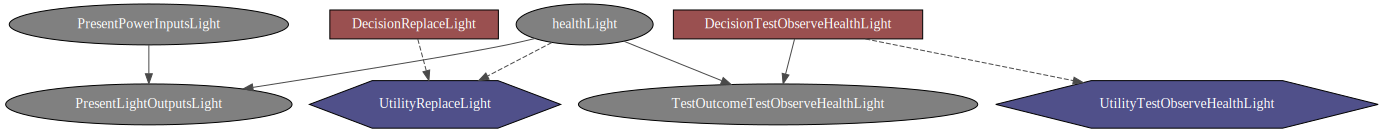

In [16]:
visualizeStructure(diagram)

In [17]:
showCPTs(diagram)

In [18]:
printUtilityTables(diagram, system)

Utility tables for component: Light


In [19]:
diagram.saveBIFXML("baselight.xml")

[Back to table of content](#table_of_content)

<a id="model_validate_system"></a>
## model and validate system (input > output) and health

**Scenario:** when power then light is normal behavior

- **Given:** evidence input power present: yes
- **And:** evidence light:on  
- **When:** inference performed
- **Then:** belief health should be health:ok

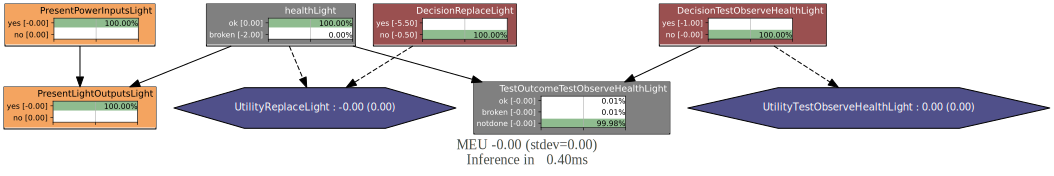

In [20]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":0
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

**Scenario:** when no power then no light is normal behavior

- **Given:** evidence input power present: no
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health should be health:ok

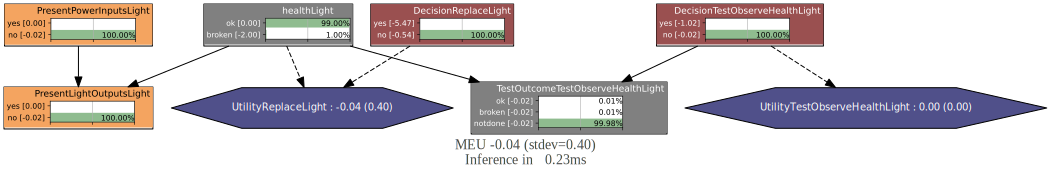

In [21]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":1,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

**Scenario:** given no light but no evidence on input power belief in health is mixed

- **Given:** no evidence input power
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health ok/broken is 50/50

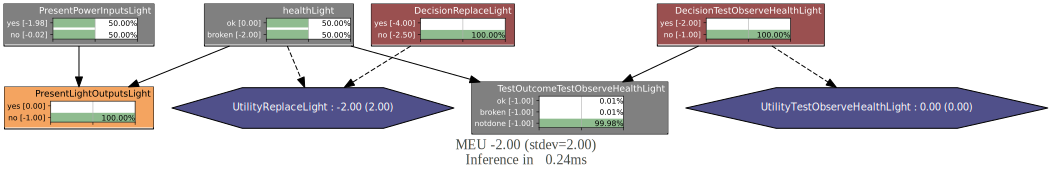

In [22]:
gnb.showInference(diagram, evs={
#    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

**Scenario:** given no light and no power on input belief health: broken, no normal behavior

- **Given:** evidence input power present: no
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health should be health:broken

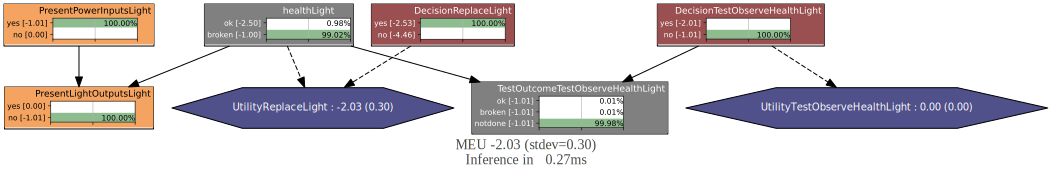

In [23]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

**Scenario:** given there is light but no power

- **Given:** evidence input power present: no
- **And:** evidence light:yes
- **When:** inference performed
- **Then:** belief health should be health:broken

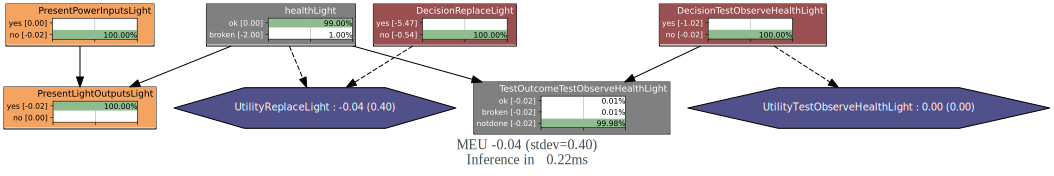

In [24]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":1,
    "PresentLightOutputsLight":0,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

The last 2 cases are due to the following table in specs for component light that defines normal behavior:

    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "no", "yes",    "no"], 
            'PresentLightOutputs': ["yes", "no", "no",    "yes"],
            'health':              ["ok",  "ok", "broken", "broken"]
            


Summary 
- given the utilities and probabilities in the system the modelling of the relation between input and output + impact on health are as expected
- Question: the behavior table can also be used to model expected failure: failure modes.. Or should failture modes be modelled differently?

[Back to table of content](#table_of_content)

<a id="model_validate_decision"></a>
## modelling and validating decision replace

### **Scenario:** given belief component health:broken advice to replace:yes

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health light:broken
- **And:** advice replace light:yes

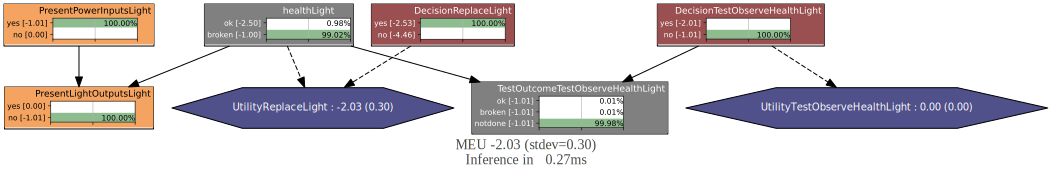

In [25]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

result follows from preferencetable for decision, when health:broken preference for replacedecision: yes (-2 > -4)

In [26]:
gnb.flow.row(diagram.utility("UtilityReplaceLight"))

### berekening UtilityReplaceLight

utility belief Health + replace yes berekening: .9902 * -2 + .0098 * -5 = -2,03

utility belief health + replace no berekening: .9902 * -4 + .0098 * -0 = -3,96

### **Scenario:** changed preferences: when broken not replacing becomes preffered

In [27]:
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,0] = -5
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,1] = 0
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,0] = -6
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,1] = -4

In [28]:
gnb.flow.row(diagram.utility("UtilityReplaceLight"))

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health light:broken
- **And:** advice replace light:no

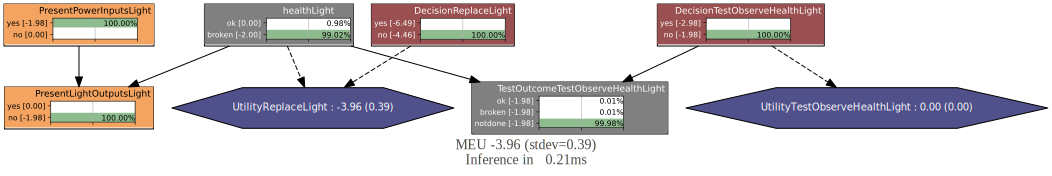

In [29]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

When system not producing output + health indicates is broken > decision to replace is no due to utility table


### **Scenario:** reset preferences if broken, replace is preferred, change utility when ok to high values and prefer no replace


In [30]:
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,0] = 50000
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,1] = 100000
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,0] = -2
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,1] = -4

In [31]:
gnb.flow.row(diagram.utility("UtilityReplaceLight"))

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health light:broken
- **And:** advice replace light:no

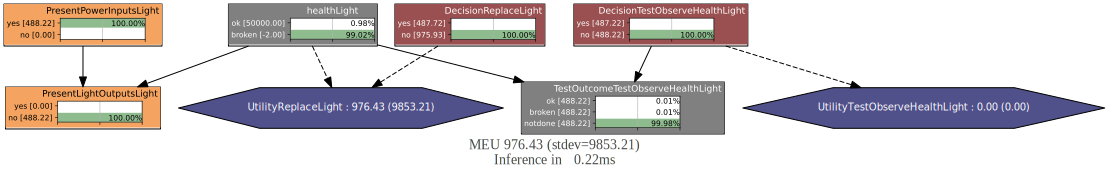

In [32]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

### berekening UtilityReplaceLight

utility belief Health + replace yes berekening: .9902 * -2 + .0098 * 50000 = 488

utility belief health + replace no berekening: .9902 * -4 + .0098 * 100000 = 976,04

#### reset UtilityReplaceLight

In [33]:
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,0] = -5
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,1] = 0
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,0] = -2
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,1] = -4

In [34]:
gnb.flow.row(diagram.utility("UtilityReplaceLight"))

summary 
- impact of preferences and probabilities becomes clear, given very high utility decision flips even given p(0.0098)
- replacing a component while health:ok is not logical, a high utility for this situation will not be set

[Back to table of content](#table_of_content)

<a id = "modelling_validating_tests"> </a>
## modelling and validating tests

Test aims to check the health of a light, simple example would be to check if wire of a light is broken. 

#### Following is taken from Joep Beurskens but edited, <a class="mycomment">comments in red</a>

##### modeling a test:
- Performing a test yields a test result that is modeled as a dummy random variable: Test, with states matching the various test results.  
<div class="mycomment"> Should test outcome be in the initial diagram or should it be introduced when test is done? Test outcome impacts health 1:1, why not use health for testoutcome?</div>
- The influence diagram includes a decision variable, T , with states (t1 = no, t2 = yes), denoting whether or not the test is suggested. 
- If the test is carried out, the outcome is made available to the decision-maker (link Testn to Dn). If, on the other hand, the test is not done, no test results are available. The link from Testn to Dn specifies that the value of Testn is known when making the corrective maintenance decision Dn.
<div class="mycomment"> Test outcome can also impact replacement decision via impact on health? Belief in health is known before replacement decision is taken?</div>
- The influence diagram also includes a utility function, U ∈ U, that specifies the cost of the test.

##### value of the test:
The test establishes the value of information according to the extent to which it might **reduce the expected costs of uncertainty by reducing uncertainty** in the evidence base. This entails evaluating the expected value of a decision made with and without additional information. When payoffs are represented in monetary terms, an explicit monetary valuation of the expected value of information is provided, which may then be directly contrasted against the expected cost of information to evaluate if it is valuable. 
<div class="mycomment">Decision to test is not due to uncertainty but due to value of information? Why not connect health to test decision? This way would reflect the need to test when belief in health is lowered?</div>
<div class="img"><img src="pictures/afbeelding1.png" align="left" width="1000" height="600"></div>

##### alternatives modelling the not done state:
The link from Testn to Dn specifies that the value of Testn is known when making the corrective maintenance decision Dn. This cannot, however, be the case when the test is not performed. According to Kjærulff and Madsen (2008), there are two alternative options to correctly model the test result variable to behave as expected when the test is not performed. Both options consider the specification of the conditional probability distribution (CPT) P (T estn|Hn, Tn) in different ways. Table 5.3 handles this by specifying P (T estn|Hn, Tn = no) as a uniform distribution. Table 5.4 introduced an additional not done state, such that not performing the test instantiates that state.

<div class="img"><img src="pictures/afbeelding2.png" align="left" width="1000" height="600"></div>

The second option is more semantically clear than the first one because it is self-evident that if the test is not performed, Testn should be instantiated to not done. However, by introducing the additional not done state in the Testn variable, the model’s complexity increases. For the sake of convenience, it is chosen to continue with the latter option. 

##### impact outcome of the test:
Note that there is no uncertainty when performing a test, i.e., Tn = yes → P (T estn = pos) = 1 ∨ P (T estn = neg) = 1. The assessment of the value of information is called the “expected value of perfect information” (EVPI) because it quantifies the value of acquiring perfect information about all aspects of the decision (eliminating all uncertainty). This does not have to be the case that all the uncertainty of a variable is eliminated. **However, it is assumed that all tests are perfect.**
<div class="mycomment">If tests are perfect why not impact health directly?</div>



[Back to table of content](#table_of_content)

<a id="joep_component_health_test"></a>
## validating component health test

we should use diagram as specified in master thesis Joep Beurskens but current state of diagram is:

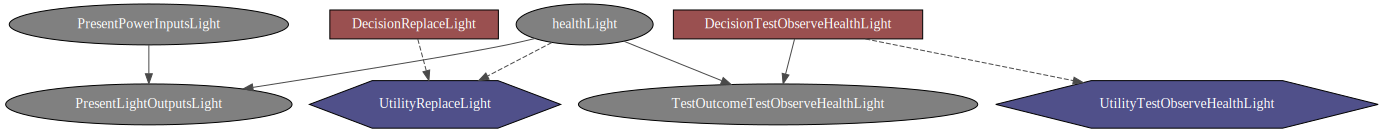

In [35]:
gnb.showInfluenceDiagram(diagram, size=1000)

Testoutcome should be made available to decisionreplacelight

In [36]:
diagram.addArc(diagram.idFromName("TestOutcomeTestObserveHealthLight"), diagram.idFromName("DecisionReplaceLight"))

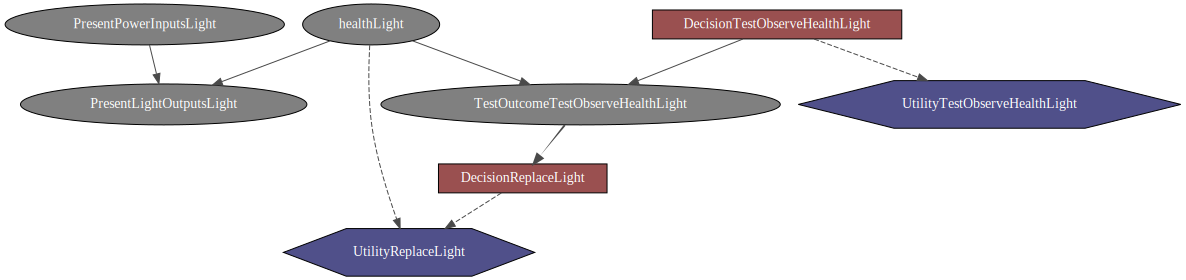

In [37]:
gnb.showInfluenceDiagram(diagram, size=1000)

### **Scenario:** given belief component health:broken, test should be triggered (but it is not!)

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health light:broken
- **And:** advice replace light:yes
- **And:** advice observe component should be yes

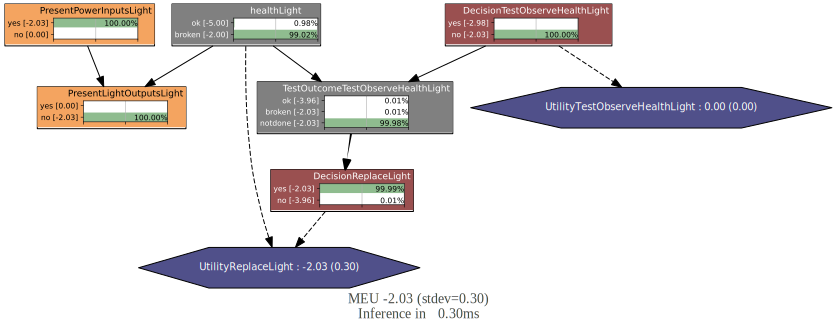

In [38]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

 <div class=mycomment> why is test decision:no?</div>

- is it already clear a component needs replacing? if so how to test?

### **Scenario:** given belief component health:broken, impact of preferences

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **When:** inference performed
- **Then:** belief health light:broken
- **And:** advice replace light:yes
- **And:** advice observe component should be yes

In [39]:
diagram.utility("UtilityTestObserveHealthLight")

,UtilityTestObserveHealthLight
DecisionTestObserveHealthLight,0
yes,-1.0000
no,0.0000


so no is preferred, what if we flip preference?

In [40]:
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0] = 1  #yes
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1] = 0  #no

In [41]:
diagram.utility("UtilityTestObserveHealthLight")

,UtilityTestObserveHealthLight
DecisionTestObserveHealthLight,0
yes,1.0000
no,0.0000


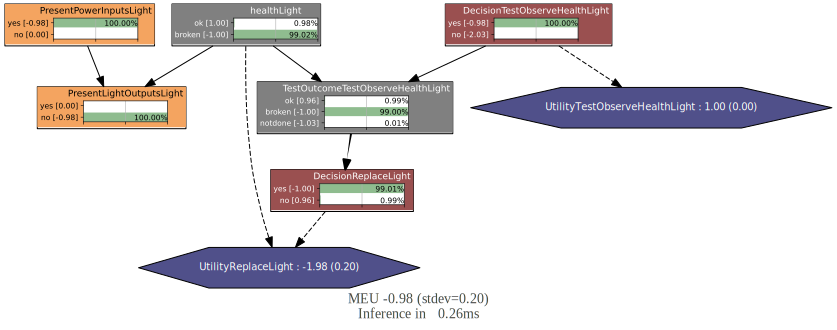

In [42]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

preferred options has flipped, next step: what is impact of TestOutcomeTestObserveHealthLight?

cpt should be set according to table 5.4  

<div class="img"><img src="pictures/table54.png" align="left" width="500" height="600"></div>

H0 is component in good condition

In [43]:
diagram.cpt(diagram.idFromName("TestOutcomeTestObserveHealthLight"))

(pyAgrum.Potential<double>@0x37461140) 
             ||  TestOutcomeTestObserveHealt|
Decisi|health||ok       |broken   |notdone  |
------|------||---------|---------|---------|
yes   |ok    || 0.9999  | 0.0001  | 0.0001  |
no    |ok    || 0.0001  | 0.0001  | 0.9999  |
yes   |broken|| 0.0001  | 0.9999  | 0.0001  |
no    |broken|| 0.0001  | 0.0001  | 0.9999  |

In [44]:
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0] = -1  #yes
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1] = 0   #no

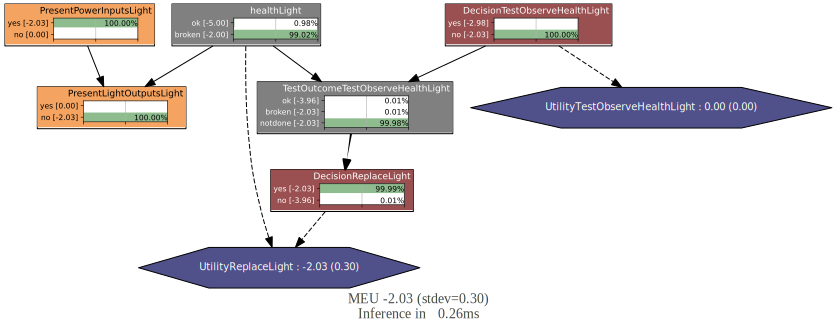

In [45]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

Observations:
- DecisionReplaceLight is not impacted by TestOutcomeTestObserveHealthLight, the arc only indicates the testoutcome is known before decision is made.
- Even though belief in health of component is broken the testoutcome states not done due to DecisionTestObserveHealthLight:no
- DecisionTestObserveHealthLight will only indicate yes if the default preference is set that way? <a class="mycomment"> How to flip the decision without changing the preference? Should health > utility or is there another way to get to yes when belief:broken?</a>

let's try increasing utility replacelight * 100

In [46]:
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,0] = -500
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,1] = 0
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,0] = -200
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,1] = -400

In [47]:
diagram.utility("UtilityReplaceLight")

(pyAgrum.Potential<double>@0x374f83c0) 
             ||  Utility|
Decisi|health||0        |
------|------||---------|
yes   |ok    || -500.0000|
no    |ok    || 0.0000  |
yes   |broken|| -200.0000|
no    |broken|| -400.0000|

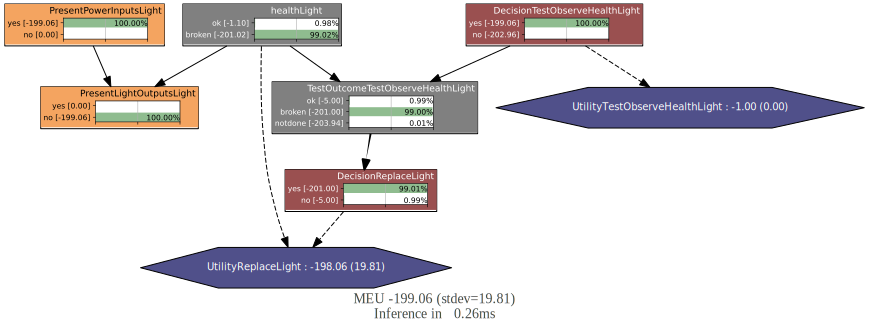

In [48]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "yes",
#    "TestOutcomeTestObserveHealthLight":0,
#   "DecisionTestObserveHealthLight": "yes",
}, size=40)

Why does a test decision indicate decision:yes when the prefered option according to it's utility is to do nothing.

- EB(Test) = EU(Test = yes)EU(Test = no)
- MEU(testlight:yes, replace:yes) = -199,06
- MEU(testlight:no, replace:yes) = -202,94

seems to be due to 0,99% remaining chance for replace light:no + the way inference works

### **Scenario:** given belief component health:broken is mixed, test should be triggered

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **And:** belief health is uncertain
- **When:** inference performed
- **And:** advice replace light:yes
- **And:** advice observe component should be yes

In [49]:
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,0] = -11
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,1] = 0
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,0] = -2
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,1] = -4

In [50]:
diagram.utility("UtilityReplaceLight")

(pyAgrum.Potential<double>@0x374f83c0) 
             ||  Utility|
Decisi|health||0        |
------|------||---------|
yes   |ok    || -11.0000|
no    |ok    || 0.0000  |
yes   |broken|| -2.0000 |
no    |broken|| -4.0000 |

Belief in health can be specified as soft evidence, per state a probability can be specified to indicate how much certainty there is about this state. Example is that if output of the light is on there is certainty about this but if it is off this can be due to other factors and so is less certain.

belief in health can be specified this way:
- belief health: ok is fairly certain
- belief health: broken is less certain

Consequence of this could be that there is more uncertainty in the rest of the model and so a test is triggered faster. Below tries this concept according to the statements on belief health mentioned above.

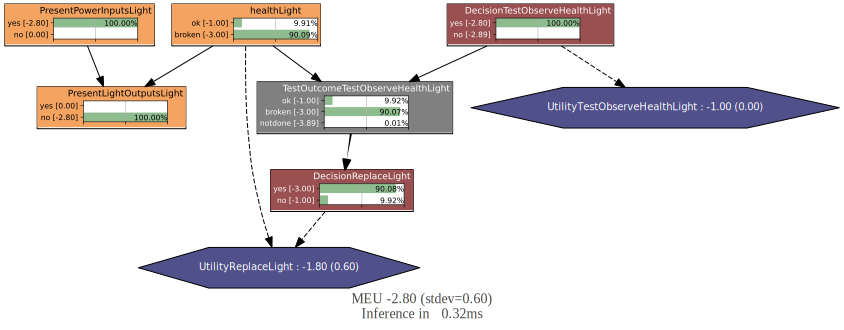

In [51]:
# given settings below a setting of Health:ok / Replace:yes switches the test decision when > 10

gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
    "healthLight":[0.9999,0.09],
#    "DecisionReplaceLight": "yes",
#    "TestOutcomeTestObserveHealthLight":0,
#   "DecisionTestObserveHealthLight": "yes",
}, size=40)

point to flip decision is at 10 vs 11

### **Scenario:** given normal behavior and health:OK, test should not be triggered

- **Given:** evidence input power present: yes
- **And:** evidence light:yes
- **When:** inference performed
- **Then:** belief health light:ok
- **And:** advice observe component should be no

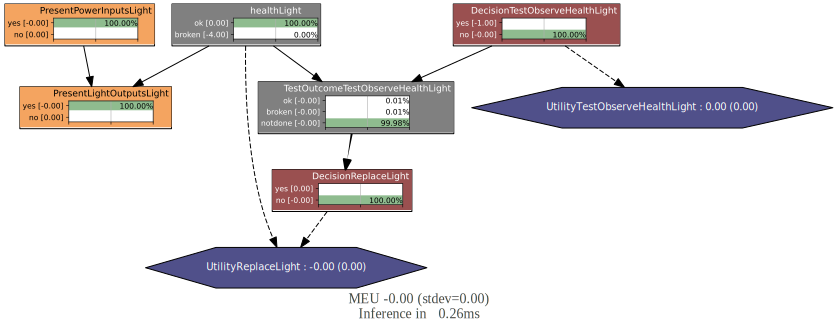

In [52]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":0,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

however test is not set to no due to health but due to preference of utility

In [53]:
diagram.utility("UtilityTestObserveHealthLight")

,UtilityTestObserveHealthLight
DecisionTestObserveHealthLight,0
yes,-1.0000
no,0.0000


### **Scenario:** given health:broken and decision to test:yes testoutcome follows health

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **And:** evidence test observehealthlight:yes
- **When:** inference performed
- **Then:** belief health light:broken
- **And:** belief testoutcome:broken

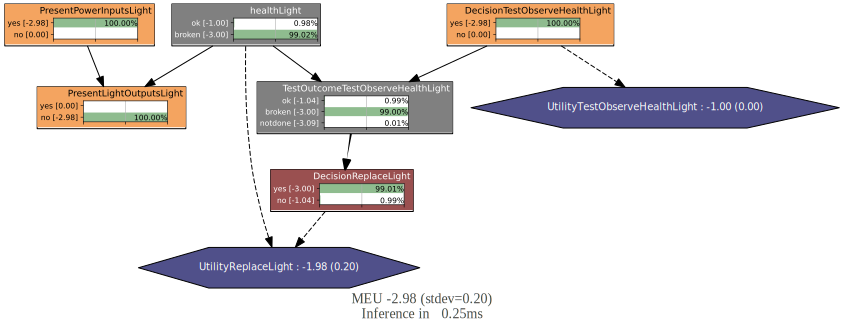

In [54]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

- **Given:** evidence input power present: yes
- **And:** evidence light:yes
- **And:** evidence test observehealthlight:yes
- **When:** inference performed
- **Then:** belief health light:ok
- **And:** belief testoutcome:ok


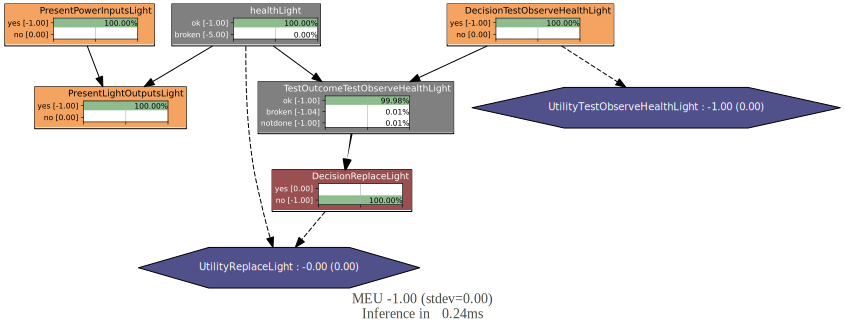

In [55]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":0,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

### **Scenario:** given decision to test:yes and testoutcome: ok > belief inhealth:ok

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **And:** evidence decision test observehealthlight:yes
- **And:** evidence testoutcome:ok
- **When:** inference performed
- **Then:** belief health light:ok

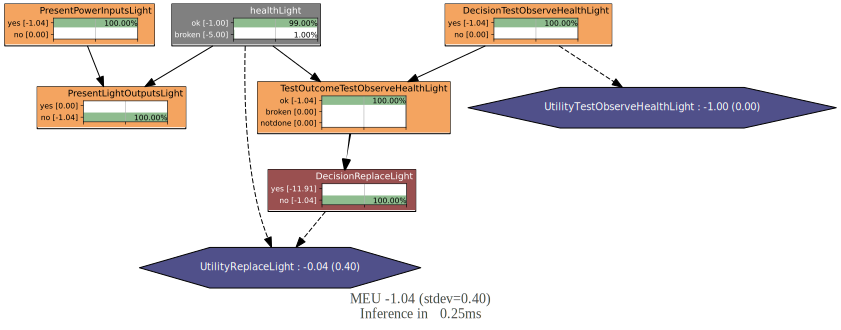

In [56]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
    "TestOutcomeTestObserveHealthLight":0,
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

why is evidence from the system output suggesting a broken system ignored when testoutcome indicate system is ok?

### **Scenario:** given decision to test:yes and testoutcome: broken > belief health:broken

- **Given:** evidence input power present: yes
- **And:** evidence light:no
- **And:** evidence decision test observehealthlight:yes
- **And:** evidence testoutcome:broken
- **When:** inference performed
- **Then:** belief health light:broken

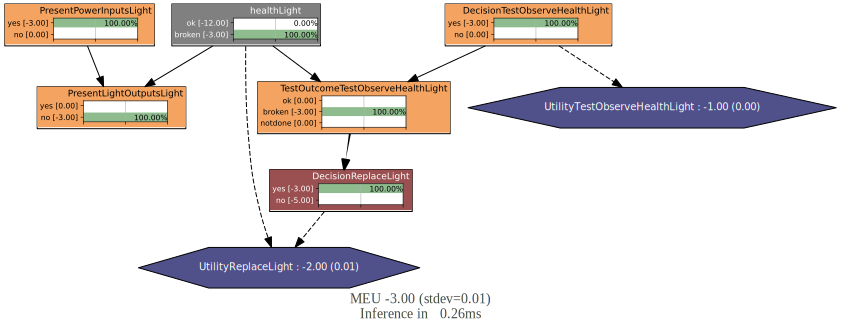

In [57]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
    "TestOutcomeTestObserveHealthLight":1,
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

### **Scenario:** given normal behavior but decision to test:yes and testoutcome: broken > belief health:broken

- **Given:** evidence input power present: yes
- **And:** evidence light:yes
- **And:** evidence decision test observehealthlight:yes
- **And:** evidence testoutcome:broken
- **When:** inference performed
- **Then:** belief health light:broken

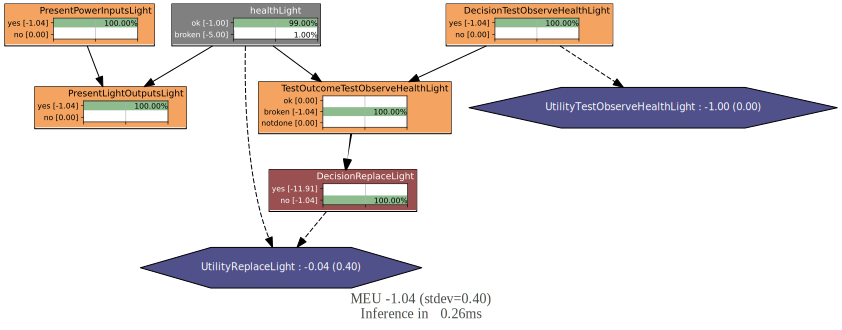

In [58]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":0,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
    "TestOutcomeTestObserveHealthLight":1,
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

Why does evidence from system take precedence over testoutcome when influencing healthlight?

<h3 class="mycomment">Summary</h3>

- when utility is not impacted by a chance variable uncertainty must come from other places to flip the test decision, a direct way should be more clear.
- testoutcome only has value when decision to test is true, otherwise it is notdone > if tests are perfect it is easier to set health to ok or broken based on the result of the test.


[Back to table of content](#table_of_content)

<a id = "component_health_test_ID"> </a>
## modelling and validating component health test, ID

Does the outcome change when instead of a limid an original influence diagram is used? let's try...


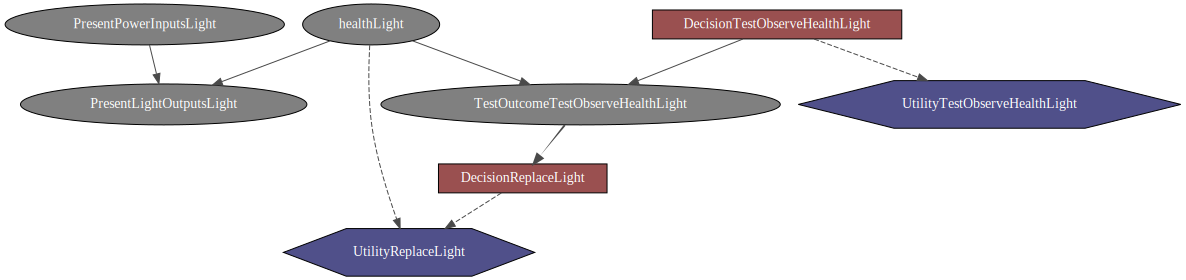

In [59]:
gnb.showInfluenceDiagram(diagram, size=200)

In [60]:
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,0] = -500
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[0,1] = 0
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,0] = -200
diagram.utility(diagram.idFromName("UtilityReplaceLight"))[1,1] = -400

In [61]:
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0] = -10
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1] = 0

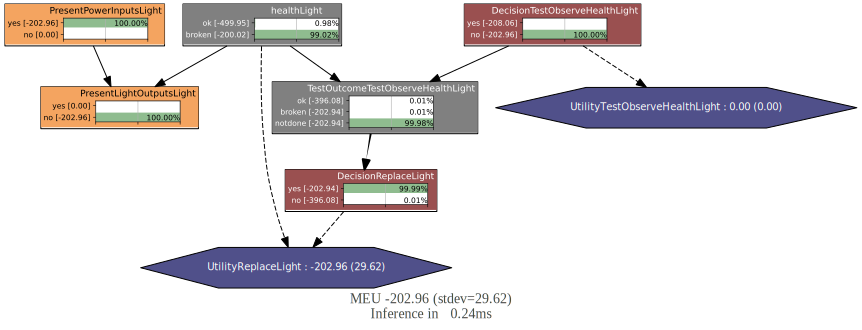

In [62]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

### same via influence diagram with specified noForgettingAssumption

In [63]:
evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.makeInference()

In [64]:
ie.hasNoForgettingAssumption()

False

In [65]:
diagram.getDecisionGraph()

(pyAgrum.DAG@0x37791ce0) {3,5} , {5->3}

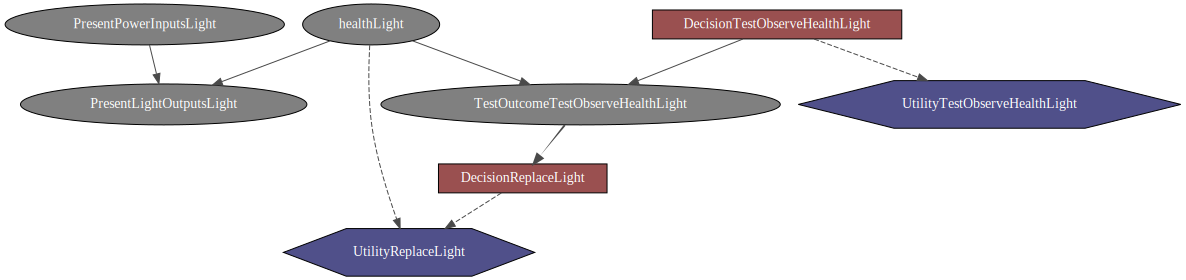

In [66]:
gnb.showInfluenceDiagram(ie.reducedLIMID(), size=1000)

In [67]:
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

In [68]:
ie.addNoForgettingAssumption(["DecisionTestObserveHealthLight","DecisionReplaceLight"])
#ie.addNoForgettingAssumption(["DecisionReplaceLight","DecisionTestObserveHealthLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

In [69]:
ie.hasNoForgettingAssumption()

True

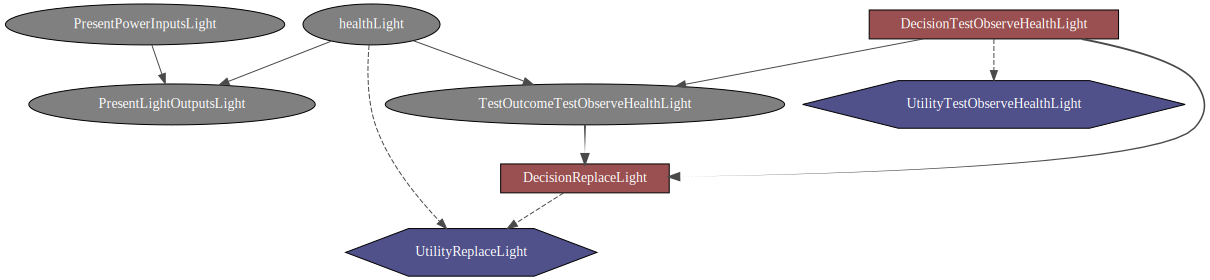

In [70]:
gnb.showInfluenceDiagram(ie.reducedLIMID(), size=1000)

In [71]:
diagram.getDecisionGraph()

(pyAgrum.DAG@0x3777d380) {3,5} , {5->3}

Summary: it doesn't matter if a LIMID is used or an Influence Diagram

[Back to table of content](#table_of_content)

<a id="improved_test"></a>
## model and validate improved health test

adding component: Light
adding cpt for component: Light
adding Replace decision for component: Light
adding Replace utility for component: Light
adding test: TestObserveHealth to component: Light


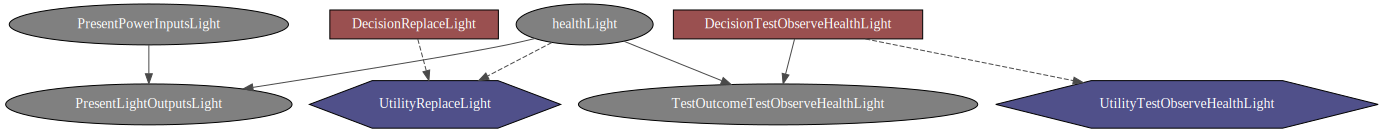

In [72]:
# create diagram object
diagram = gum.InfluenceDiagram()
diagram = builder.diagramBuilder(diagram, system)
gnb.showInfluenceDiagram(diagram, size=300)

In [73]:
diagram.eraseArc("healthLight","TestOutcomeTestObserveHealthLight")
diagram.eraseArc("DecisionTestObserveHealthLight","TestOutcomeTestObserveHealthLight")
diagram.erase(diagram.idFromName("TestOutcomeTestObserveHealthLight"))

In [74]:
diagram.addArc("healthLight", "UtilityTestObserveHealthLight")

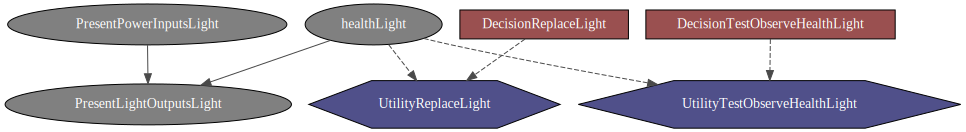

In [75]:
gnb.showInfluenceDiagram(diagram, size=300)

In [76]:
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0,0] = -5  # health:ok, decision:yes
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0,1] = 0   # health:ok, decision:no
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1,0] = -2  # health:broken, decision:yes  
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1,1] = -4  # health:broken, decision:no

In [77]:
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))

(pyAgrum.Potential<double>@0x374f7590) 
             ||  Utility|
Decisi|health||0        |
------|------||---------|
yes   |ok    || -5.0000 |
no    |ok    || 0.0000  |
yes   |broken|| -2.0000 |
no    |broken|| -4.0000 |

### **Scenario:** observe test decision should behave as decision replacelight given identical utility table

four cases:
- **light working:**, after inference decision to test is no
- **light not working:**, after inference decision to test is yes
- **decision test is taken:** result health:ok, no replacing adviced
- **decision test is taken:** result health:broken, replacing adviced

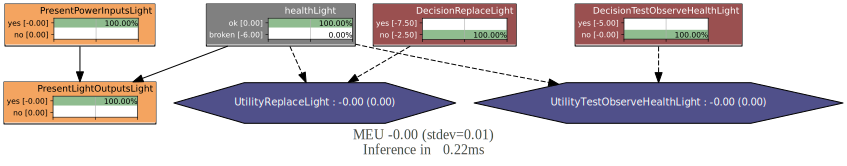

In [78]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":0,
#    "healthLight":0,
#    "DecisionReplaceLight": "no",
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

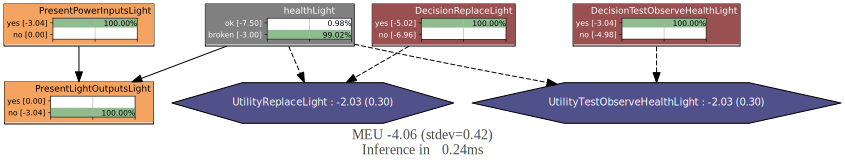

In [79]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":0,
#    "DecisionReplaceLight": "no",
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

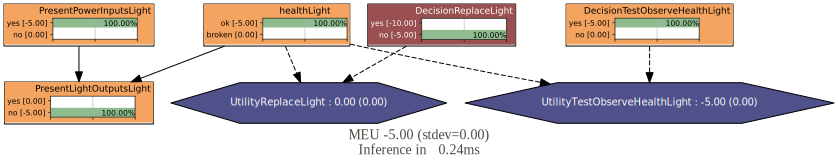

In [80]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
    "healthLight":0,
#    "DecisionReplaceLight": "no",
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

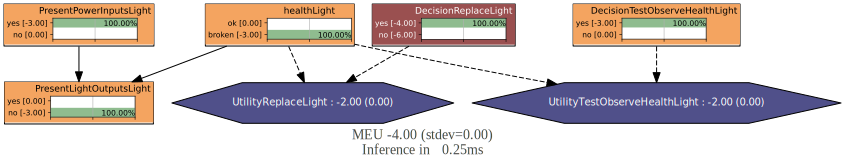

In [81]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
    "healthLight":1,
#    "DecisionReplaceLight": "no",
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

[Back to table of content](#table_of_content)

<a id="output_test"></a>
## model and validate output test

##### other testtypes:
Up till now the set of possible tests exists out of tests that test components in isolation, as seen in Figure 5.4. However, such a test may not exist for some triggers, such as T3. 
- An additional observation can be made by measuring the voltage at the wire ends. This test is likely cheaper than checking the health of each component individually, and it might improve the reliability of the model the most. 
The network will look like Figure 5.5 if the measurement tests (T6, T7) are included but not the trigger test (T3). Measuring a voltage at the output of Iwire1 indicates that it is likely that the trigger, wire2, or lamp is broken. While measuring no voltage indicates there is probably a defect in the battery and/or wire1, plus an additional chance (prior probability) that trigger, wire2, and lamp are also broken. See Appendix A for a visualization in the software of these scenarios.

<div class="img"><img src="pictures/afbeelding3.png" align="left" width="1000" height="600"></div>

The informational links from Test6 to D2 and from Test7 to D4 in Figure 5.5 indicate that the information is only available prior to making a decision on D2 and D4. However, this information is also available for all decisions. But limiting the number of information links is the main motivation of LIMID. Its solution is computationally tractable, whereas the same decision problem could be intractable if the no-forgetting condition is assumed. It is not always obvious which informational links to include in a LIMID without affecting the policies and the expected utility of the computed policies.
These are considered the building blocks for modeling the diagnosis network and are applicable to Model 2: Quadruple Light. Figure 5.6 depicts the augmented Bayesian network to an influence diagram of the network in Figure 4.6. Hence, it is assumed that every component can be tested in isolation, except for the connecting wires. These are modeled similarly to T6 and T7 (Figure 5.5), where the voltage at each wire end can be measured.


<div class="mycomment">Analysis of output test modelling</div>
     
modelling Joep:
- The modelling is similar to health test modelling but differs in that it tests presence of output instead of health.
- Utility table for this test is not explained but it is assumed it is similar to utility of health test.
- Triggering the decision to test T7 or T6 is expected to work the same as the health test, indirect via the value of information.

value:
- value of the test is clear, when output is present all components before the tested component are ok. If no output is found one or more components are in error.

improve modelling?
- trigger to test is again based on "value of information" but could also be based on health node as input to the utility of this test.
- the testoutcome is connected to output node to model impact of test on outcome. same as with health: why not set outcome as evidence on outputnode

alternative to finding problem causing component
- Via binary search steps a component that is in error could be found quickly. But influence diagrams don't support binary search.

example:
- Observation: output of the last component in the chain is not working, like no light.
- Given the chain contains 4 components and 3 connections which one to test?
- The output test connected to output node could trigger a decision: "perform binary search output test". This would trigger a test in the n/2 compenent that come before the component with no output. 

can the model predict which model is the problem?
- maybe via health 
            

[Back to table of content](#table_of_content)

<a id="other_tests"></a>
## model and validate other testtypes

#### Problem/Observation: no printed sheet entered as evidence

<div class="img"><img src="pictures/Afbeelding4.png" align="left" width="500" height="300"></div>




- **Given:** observation no printed sheet
- **And:** command:copy issued
- **When:** inference performed
- **Then:** belief inktjetter could be broken

#### Additional observation: bitmap checked, entered as evidence

<div class="img"><img src="pictures/Afbeelding5.png" align="left" width="500" height="300"></div>


The situation above can be defined by a scenario written by a system engineer

Scenario: no printed sheets > check bitmap
- **Given:** observation printed sheet:no
- **And:** observation command:copy issued
- **When:** assessing the situation
- **Then:** advice testtype outputcheck for output node of component ImageProcessor, modality bitmap

testtype outputcheck parameters: x, y, z

Scenario above defines what happens during diagnosis in real life and so should feel natural to specify. It is however formulated in a way that can be translated to a supporting influence diagram. Translation requires two steps:
- Scenario indicates a test of type 'outputcheck' should be implemented in the diagram for component image processor, the testtype should be known.
- Scenario indicates what advice is expected from an influence diagram after inference, this can however not be guaranteed due to all the elements in a diagram. The expected advice can be used as an acceptance test for a concept influence diagram. When the concept influence diagram does not behave as expected maybe tuning of probabilities or utilities can make sure it can adhere to the scenario.

Implementing the test into the influence diagram
- Testtype outputcheck refers to an OOPN network class
- The network class is implemented in the diagram given the specified parameters. possible parameters are:
  - values for decision: yes, no
  - costs to calculate utility table
  - values for testoutcome: ok, broken, notdone
  - values behavior table testoutcome like Decision:no > Testoutcome:notdone

The acceptance test is generated in code based on the scenario using Behavior Driven Development:
- observation: set evidence for component Inkjetter / Output node / Modality Printed Sheet:no
- observation: set evidence for component ? / Input node / Modality Command:copy
- assessing the situation > perform inference
- advice test: assert posterior decision for test to check output for component ImageProcessor, check modality bitmap:yes


after checking bitmap action
- **Given:** observation no printed sheet
- **And:** command:copy issued
- **And:** evidence bitmap present:yes
- **When:** inference performed
- **Then:** belief inktjetter:broken




OOPN network class: checkoutput
- trigger: output not as expected
- testdecision: yes/no
- utility variables: output / testdecision, high-low utility
  - not expected / test yes: cost of the test
  - not expected / test no: penalty for not testing
  - expected / test yes: penalty for checking when not necessary
  - expected / test no: 0
- testoutcome:
  - impact on health of (multiple) components


- check properties of parts of the system
- which parts to check? 1 component, multiple?
- check triggered by what? health? output?
- result of check? 


#### Send print command instead of copy, printed sheet now present
- additional situation modelled via extra nodes
- apart from health and input nodes other nodes are doubled: output
- additional nodes are childeren of health

<div class="img"><img src="pictures/Afbeelding6.png" align="left" width="500" height="300"></div>


- **Given:** observation no printed sheet
- **And:** command:copy issued
- **When:** inference performed
- **Then:** action advised send other command

do action

- **Given:** command:copy issued but no printed sheet
- **And:** command:print issued and printed sheet present
- **When:** inference performed
- **Then:** action advised check bitmap


#### Replace component, input is send to new component
- same as type II but now also health is doubled

<div class="img"><img src="pictures/Afbeelding7.png" align="left" width="500" height="300"></div>


#### intervene requires do(x)

<div class="img"><img src="pictures/Afbeelding8.png" align="left" width="500" height="300"></div>


[Back to table of content](#table_of_content)



<a id="decisions"></a>
## how to choose between decisions?



decisions are steered by:
- locally connected preference table
- contribution to overall utility (decision tree, probabilities)
- how big is the impact of health when directly connected to test decision vs via overall utility?


select between decisions
- local utility vs total utility, how much does local utility contribute?
- which decision contributes the most to overall utility? algorithm to go through all decisions switching yes/no

via modelling









In [82]:
diagram = gum.InfluenceDiagram()
diagram.loadBIFXML("baselight.xml") 


True

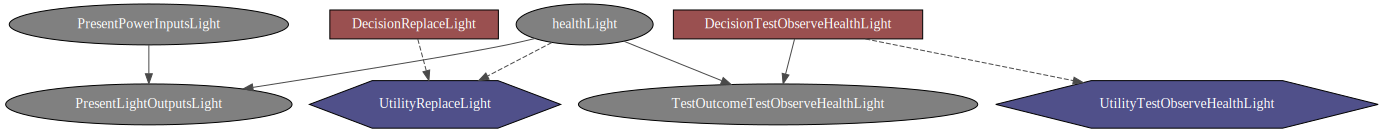

In [83]:
gnb.showInfluenceDiagram(diagram, size=1000)

In [84]:
#DecSelector = diagram.addDecisionNode(gum.LabelizedVariable('DS', 'DS', ["yes", "no"]))


In [85]:
USelector = diagram.addUtilityNode(gum.LabelizedVariable("US", "R(L1H, DT1)", 1))


In [86]:
diagram.addArc("DecisionReplaceLight", "US")
diagram.addArc("DecisionTestObserveHealthLight", "US")
diagram.addArc("healthLight", "UtilityTestObserveHealthLight")


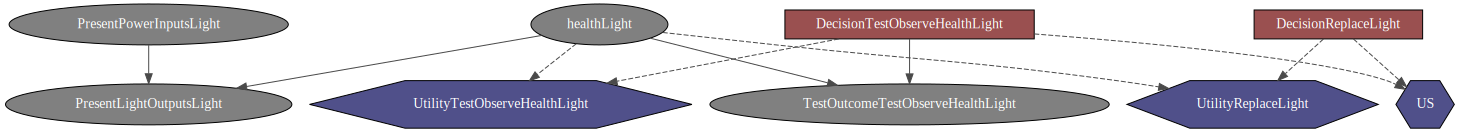

In [87]:
gnb.showInfluenceDiagram(diagram, size=1000)

In [88]:
diagram.utility("US")

(pyAgrum.Potential<double>@0x37d09060) 
             ||  US     |
Decisi|Decisi||0        |
------|------||---------|
yes   |yes   || 0.0000  |
no    |yes   || 0.0000  |
yes   |no    || 0.0000  |
no    |no    || 0.0000  |

In [89]:
diagram.utility(diagram.idFromName("US"))[0,0] = -5  # health:ok, decision:yes
diagram.utility(diagram.idFromName("US"))[0,1] = 0   # health:ok, decision:no
diagram.utility(diagram.idFromName("US"))[1,0] = -2  # health:broken, decision:yes  
diagram.utility(diagram.idFromName("US"))[1,1] = -4  # health:broken, decision:no

In [90]:
diagram.utility("UtilityTestObserveHealthLight")

(pyAgrum.Potential<double>@0x375a83a0) 
             ||  Utility|
Decisi|health||0        |
------|------||---------|
yes   |ok    || -1.0000 |
no    |ok    || 0.0000  |
yes   |broken|| 0.0000  |
no    |broken|| 0.0000  |

In [91]:
diagram.utility("UtilityReplaceLight")

(pyAgrum.Potential<double>@0x37c9b590) 
             ||  Utility|
Decisi|health||0        |
------|------||---------|
yes   |ok    || -5.0000 |
no    |ok    || 0.0000  |
yes   |broken|| -2.0000 |
no    |broken|| -4.0000 |

In [92]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

FatalError: [pyAgrum] Fatal error: This LIMID/Influence Diagram is not solvable.

In [ ]:
diagram = gum.InfluenceDiagram()
diagram.loadBIFXML("baselight.xml") 


In [ ]:
gnb.showInfluenceDiagram(diagram, size=1000)

In [ ]:
diagram.erase("UtilityTestObserveHealthLight")

In [ ]:
diagram.erase("DecisionTestObserveHealthLight")

In [ ]:
diagram.erase("DecisionReplaceLight")

In [ ]:
diagram.addDecisionNode(gum.LabelizedVariable('DS', 'DS', ["Replace", "NotReplace", "Change"]))

In [ ]:
diagram.addArc("DS", "UtilityReplaceLight")

In [ ]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

In [ ]:
diagram.utility("UtilityReplaceLight")

# einde analyse, hieronder proefstukjes

##### discussion 
- Deze structuur hebben we ook in andere literatuur teruggevonden. Maar wat voegt deze test toe? Als ik de CPT bekijk, dan zegt deze dat als bijvoorbeeld de health goed is (Hn = 0) en de test wordt gedaan (Tn=yes), dat dan de kans op een pos test 1 is. In feite is volgens deze CPT de test uitkomst een 1 op 1 "echo" van de health. 
- Het maffe is ook een beetje dat het model een decision heeft of er getest moet worden, maar dat je de uitkomst van de test niet kwijt kunt.


===================

Mijn beeld erbij is:
- Health heeft een prior die de kans aangeeft op een gezond of niet gezonde component, bijvoorbeeld 80/20
- Het testbesluit is T1 (vierkantje) en als de kosten via de utility het aangeven ga je de test doen
- Test1 is in mijn beeld de uitkomst van de test, je ziet dat ook aan de toestanden: niet gedaan, goed of niet goed
- De 1 op 1 verbinding met health duidt er denk ik op dat de test echt gericht is om de health te testen. Indien de test positief is dan zal posterior van health veranderen naar 100% positief, de onzekerheid over H is dan weg. Als de test negatief is dan is dat vervolgens ook een signaal over de health maar ook een trigger om het vervangingsbesluit te nemen: D1.

Kortom het helpt om meer zekerheid over H te krijgen en vervanging in gang te zetten (of niet).

Weet niet hoe je het ziet maar op een gegeven moment viel er bij mij een kwartje toen ik zag dat een pijl niet alleen betekent dat het onderdeel waar naar verwezen wordt verandert bij nieuwe informatie maar ook de bron van de pijl, in dit geval H.

==================

Het klopt idd wat je zegt, dat de informatie ook in tegengestelde richting van de pijlen gaat. Zoiets als, als het regent dan is de kans groot dat het seizoen herfst betreft, pijl van regen naar herfst, als we zeggen dat het herfst is dan wordt de kans dat het regent ook groter. 

Maar terug naar het Joep diagram, de "gebruiker" heeft hier alleen de beslissing dat hij/zij wel of niet de test gaat doen. Tn heeft waarde yes of no. De variabele Test1 heeft de mogelijke uitslagen van de test. De CPT tabel geeft de kansen weer dat de uitslag "not done", "pos", of "neg" zijn. Als je niet test dan is de kans 100% dat het not done is, dat lijkt me logisch.
Als je wel test en de health is 1 (health is slecht). Dan is de kans 100% dat de test negatief is en dat vind ik vreemd.
Stel de batterij health is onderdeel van een groter systeem. Daaruit volgt bijvoorbeeld dat de kans 50% is dat de batterij stuk is. Dan is de prior op dat moment 0.5/0.5 voor de batterij. Stel je geeft aan te testen, dan is de kans dat de test positief is ook 50% en de kans dat deze negatief is ook 50%.  
Kortom, op dat moment is het model nog niets verder, wel uiteraard als de test daadwerkelijk gedaan is. Maar de werkelijke uitslag van de test voegen we niet weer toe aan het model.

Naar mijn idee voegt deze CPT tabel (en dus de test niks toe). Ik ga het verder uitzoeken, kom erop terug, schrijf het ook even op om mijn idee helder te krijgen..
Het zou trouwens duidelijker zijn geweest in zo'n voorbeeld als de batterij health variabele de waarde ok en flat had i.p.v. 0 en 1. Maar dat is voor ons document.

In [ ]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
    "healthLight":1,
#    "DecisionReplaceLight": "no",
    "DecisionTestObserveHealthLight": "yes",
}, size=40)

### **Scenario:** observe test decision should behave as decision replacelight given identical utility table

- **Given:** evidence input power present: yes
- **And:** evidence light:yes
- **And:** evidence decision test observehealthlight:yes
- **And:** evidence testoutcome:broken
- **When:** inference performed
- **Then:** belief health light:broken

## inference via code met potentials en instantions

poging om utility te berekenen

In [ ]:
evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}

In [ ]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
ie.makeInference()

In [ ]:
ie.MEU()["mean"]

In [ ]:
ie.optimalDecision('DecisionReplaceLight')

In [ ]:
ie.posterior("UtilityReplaceLight")

In [ ]:
# posterior tabel is een potential p
# loop door tabel levert een instantiation (index) i
# met index kan waarde in tabel worden opgevraagd: p.get(i)

def getOptimalDecision(ie):
    p = ie.posterior("DecisionReplaceLight")
    for i in p.loopIn():
        if (p.get(i) == 1.0):
            return i # type is Instantiation

In [ ]:
i = getOptimalDecision(ie)

In [ ]:
# get value of variable in Instantation
i["DecisionReplaceLight"]

In [ ]:
def calculateUtilityEU(ie, optDecisionI):
    h = optDecisionI.variablesSequence()[0].name()
    v = optDecisionI[h]

    pu = ie.posteriorUtility("UtilityReplaceLight")
    
    p2 = ie.posterior("UtilityReplaceLight")
    i = gum.Instantiation(p2)
    
    
# todo check of waarde wel voorkomt    
    
    while (not i.end()):
        if(i[h] == v):
            print(i)
            print(p2.get(i))
            i2 = i.copy()
        i.inc()
        
    
    

In [ ]:
calculateUtilityEU(ie, i)

In [ ]:
pu = ie.posteriorUtility("UtilityReplaceLight")
for i in pu.loopIn():
    print(i)

In [ ]:
p2 = ie.posterior("UtilityReplaceLight")

In [ ]:
i2 = gum.Instantiation(p2)

In [ ]:
a = i2.variablesSequence()

In [ ]:
if (l in a):
    print("yes")

In [ ]:
# loop potential > instantiations
# pyAgrum.Potential is a multi-dimensional array with a pyAgrum.DiscreteVariable associated to each dimension. It is used to represent probabilities and utilities tables in aGrUMs’ multidimensional (graphical) models with some conventions.
# Instantiation class which represents a multi-dimensionnal index

for t in ie.posterior("UtilityReplaceLight").loopIn():
    print(t)

In [ ]:
I = gum.Instantiation(ie.posterior("UtilityReplaceLight"))
print(I)
I.inc()
print(I)
print(ie.posterior("UtilityReplaceLight").get(I))
ie.posterior("UtilityReplaceLight").set(I, 0.1)

In [ ]:
ie.posterior("UtilityReplaceLight")


In [ ]:
l = gum.LabelizedVariable("UtilityOutput", "UtilityOutput", 1)

In [ ]:
I.chgVal("healthLight", 1)

In [ ]:
I.contains("healthLight")

In [ ]:
first = I.variable(0)
second = I.variable(1)

In [ ]:
I.nbrDim()

In [ ]:
I.val(first)

## addArc health > test utility

In [ ]:
diagram.addArc(diagram.idFromName("healthLight"), diagram.idFromName("UtilityTestObserveHealthLight"))
#diagram.eraseArc(diagram.idFromName("DecisionTestObserveHealthLight"), diagram.idFromName("TestOutcomeTestObserveHealthLight"))

In [ ]:
gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
    "TestOutcomeTestObserveHealthLight":0,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

misschien moet testoutcome altijd als evidence meegegeven worden want het is geen belief punt?

In [ ]:
printUtilityTables(diagram, system)

In [ ]:
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0,0] = -5
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[0,1] = 0
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1,0] = -2
diagram.utility(diagram.idFromName("UtilityTestObserveHealthLight"))[1,1] = -4

In [ ]:
diagram.cpt('TestOutcomeTestObserveHealthLight')[0, 0, 0] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[0, 1, 0] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[0, 0, 1] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[0, 1, 1] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[0, 0, 2] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[0, 1, 2] = 0.3

diagram.cpt('TestOutcomeTestObserveHealthLight')[1, 0, 0] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[1, 1, 0] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[1, 0, 1] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[1, 1, 1] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[1, 0, 2] = 0.3
diagram.cpt('TestOutcomeTestObserveHealthLight')[1, 1, 2] = 0.3




In [ ]:
gnb.flow.row(diagram.cpt(diagram.idFromName("TestOutcomeTestObserveHealthLight")))

## add extra utility

In [ ]:
UtilityOutput=diagram.addUtilityNode(gum.LabelizedVariable("UtilityOutput", "UtilityOutput", 1))

In [ ]:
diagram.addArc(diagram.idFromName("PresentLightOutputsLight"), UtilityOutput)

In [ ]:
diagram.utility(UtilityOutput)[0] = 100 
diagram.utility(UtilityOutput)[1] = 0 

In [ ]:
# when evidence shows no light but input power present > belief health: broken

gnb.showInference(diagram, evs={
    "PresentPowerInputsLight":0,
    "PresentLightOutputsLight":1,
#    "healthLight":1,
#    "DecisionReplaceLight": "no",
#    "TestOutcomeTestObserveHealthLight":1,
#    "DecisionTestObserveHealthLight": "yes",
}, size=40)

In [ ]:
UtilityAggregate=diagram.addUtilityNode(gum.LabelizedVariable("UtilityAgg", "UtilityAgg", 1))

In [ ]:
diagram.addArc(diagram.idFromName("UtilityOutput"), diagram.idFromName("UtilityAgg"))
diagram.addArc(diagram.idFromName("UtilityReplaceLight"), diagram.idFromName("UtilityAgg"))